# Find the higher priced homes

## Normal inputs

In [124]:
# Import statements
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from itertools import combinations
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.style.use('seaborn-colorblind')
%matplotlib inline

In [2]:
# Read in cleaned Kings County file 
df = pd.read_csv("cleaned_kings.csv")
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])
df.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  01/01/1970  221900.0         3       1.00         1180   
1  6414100192  01/01/1970  538000.0         3       2.25         2570   
2  5631500400  01/01/1970  180000.0         2       1.00          770   
3  2487200875  01/01/1970  604000.0         4       3.00         1960   
4  1954400510  01/01/1970  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21420 entries, 0 to 21419
Data columns (total 21 columns):
id               21420 non-null int64
date             21420 non-null object
price            21420 non-null float64
bedrooms         21420 non-null int64
bathrooms        21420 non-null float64
sqft_living      21420 non-null int64
sqft_lot         21420 non-null int64
floors           21420 non-null float64
waterfront       21420 non-null int64
view             21420 non-null int64
condition        21420 non-null int64
grade            21420 non-null int64
sqft_above       21420 non-null int64
sqft_basement    21420 non-null int64
yr_built         21420 non-null int64
yr_renovated     21420 non-null int64
zipcode          21420 non-null int64
lat              21420 non-null float64
long             21420 non-null float64
sqft_living15    21420 non-null int64
sqft_lot15       21420 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.4+ MB


# Prices
* Houses range in price from \\$78,000 to \\$770,000 
* Average price is around \\$450,550 
* Upper 25% begins at \\$645,000

[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

count    2.142000e+04
mean     5.418614e+05
std      3.675569e+05
min      7.800000e+04
25%      3.249500e+05
50%      4.505500e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

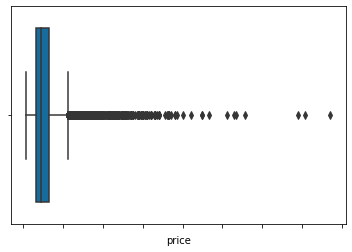

In [4]:
# Create boxplot for price
chart = sns.boxplot(x='price', data=df,);
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
# Show data for price
df.price.describe()

## Use values at the 75th percentile and above to find the higher priced homes

In [5]:
hp_homes = df[df['price'] >= 645000]
hp_homes = hp_homes.drop(columns='date')
hp_homes


id      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
5      7237550310  1230000.0         4       4.50         5420    101930   
10     1736800520   662500.0         3       2.50         3560      9796   
15     9297300055   650000.0         4       3.00         2950      5000   
21     2524049179  2000000.0         3       2.75         3050     44867   
26     1794500383   937000.0         3       1.75         2450      2691   
...           ...        ...       ...        ...          ...       ...   
21403  7502800100   679950.0         5       2.75         3600      9437   
21404   191100405  1580000.0         4       3.25         3410     10125   
21406  7202300110   810000.0         4       3.00         3990      7838   
21407   249000205  1540000.0         5       3.75         4470      8088   
21413  7936000429  1010000.0         4       3.50         3510      7200   

       floors  waterfront  view  condition  grade  sqft_above  sqft_basement  \
5         1.0           0     0          3     11        3890           1530   
10        1.0           0     0          3      8        1860           1700   
15        2.0           0     3          3      9        1980            970   
21        1.0           0     4          3      9        2330            720   
26        2.0           0     0          3      8        1750            700   
...       ...         ...   ...        ...    ...         ...            ...   
21403     2.0           0     0          3      9        3600              0   
21404     2.0           0     0          3     10        3410              0   
21406     2.0           0     0          3      9        3990              0   
21407     2.0           0     0          3     11        4470              0   
21413     2.0           0     0          3      9        2600            910   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
5          2001             0    98053  47.6561 -122.005           4760   
10         1965             0    98007  47.6007 -122.145           2210   
15         1979             0    98126  47.5714 -122.375           2140   
21         1968             0    98040  47.5316 -122.233           4110   
26         1915             0    98119  47.6386 -122.360           1760   
...         ...           ...      ...      ...      ...            ...   
21403      2014             0    98059  47.4822 -122.131           3550   
21404      2007             0    98040  47.5653 -122.223           2290   
21406      2003             0    98053  47.6857 -122.046           3370   
21407      2008             0    98004  47.6321 -122.200           2780   
21413      2009             0    98136  47.5537 -122.398           2050   

       sqft_lot15  
5          101930  
10           8925  
15           4000  
21          20336  
26           3573  
...           ...  
21403        9421  
21404       10125  
21406        6814  
21407        8964  
21413        6200  

[5394 rows x 20 columns]

### General description of hp_homes data

In [6]:
hp_homes.describe()
hp_homes.info()

id         price     bedrooms    bathrooms   sqft_living  \
count  5.394000e+03  5.394000e+03  5394.000000  5394.000000   5394.000000   
mean   4.506411e+09  9.850683e+05     3.821098     2.671950   2994.090286   
std    2.938175e+09  4.764987e+05     0.893178     0.788766   1025.963639   
min    1.200019e+06  6.450000e+05     1.000000     0.750000    890.000000   
25%    1.931300e+09  7.200000e+05     3.000000     2.250000   2320.000000   
50%    3.885803e+09  8.250000e+05     4.000000     2.500000   2880.000000   
75%    7.301550e+09  1.050000e+06     4.000000     3.250000   3500.000000   
max    9.839301e+09  7.700000e+06    10.000000     8.000000  13540.000000   

           sqft_lot       floors   waterfront         view    condition  \
count  5.394000e+03  5394.000000  5394.000000  5394.000000  5394.000000   
mean   2.130917e+04     1.712180     0.022989     0.618465     3.462180   
std    6.032924e+04     0.496588     0.149881     1.189671     0.686927   
min    5.200000e+02     1.000000     0.000000     0.000000     1.000000   
25%    5.400000e+03     1.000000     0.000000     0.000000     3.000000   
50%    8.572000e+03     2.000000     0.000000     0.000000     3.000000   
75%    1.432850e+04     2.000000     0.000000     0.000000     4.000000   
max    1.651359e+06     3.500000     1.000000     4.000000     5.000000   

             grade   sqft_above  sqft_basement     yr_built  yr_renovated  \
count  5394.000000  5394.000000    5394.000000  5394.000000   5394.000000   
mean      8.836300  2529.935669     454.645903  1972.809047    130.842603   
std       1.223151   983.546134     569.009775    32.563334    494.502881   
min       5.000000   580.000000       0.000000  1900.000000      0.000000   
25%       8.000000  1750.000000       0.000000  1951.000000      0.000000   
50%       9.000000  2425.000000       0.000000  1981.000000      0.000000   
75%      10.000000  3150.000000     880.000000  2001.000000      0.000000   
max      13.000000  9410.000000    4820.000000  2015.000000   2015.000000   

            zipcode          lat         long  sqft_living15     sqft_lot15  
count   5394.000000  5394.000000  5394.000000    5394.000000    5394.000000  
mean   98073.790137    47.619604  -122.202968    2614.312013   16247.212088  
std       51.287435     0.075225     0.135894     781.125064   35175.165901  
min    98001.000000    47.159300  -122.514000     860.000000     967.000000  
25%    98033.000000    47.570900  -122.314000    2010.000000    5250.000000  
50%    98074.000000    47.629800  -122.209000    2570.000000    8406.500000  
75%    98115.000000    47.673200  -122.105000    3130.000000   12925.500000  
max    98199.000000    47.776400  -121.691000    6210.000000  871200.000000

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5394 entries, 5 to 21413
Data columns (total 20 columns):
id               5394 non-null int64
price            5394 non-null float64
bedrooms         5394 non-null int64
bathrooms        5394 non-null float64
sqft_living      5394 non-null int64
sqft_lot         5394 non-null int64
floors           5394 non-null float64
waterfront       5394 non-null int64
view             5394 non-null int64
condition        5394 non-null int64
grade            5394 non-null int64
sqft_above       5394 non-null int64
sqft_basement    5394 non-null int64
yr_built         5394 non-null int64
yr_renovated     5394 non-null int64
zipcode          5394 non-null int64
lat              5394 non-null float64
long             5394 non-null float64
sqft_living15    5394 non-null int64
sqft_lot15       5394 non-null int64
dtypes: float64(5), int64(15)
memory usage: 885.0 KB


### Higher Priced Homes Summary

In [7]:
# Made a chart to use in presentation slide deck
summaries = []
for item in hp_homes:
    d = {}
    d['item'] = item
    d['min'] = hp_homes[item].min()
    d['max'] = hp_homes[item].max()
    d['median'] = hp_homes[item].median()
    summaries.append(d)

# Summary data from hp_homes
summaries_df = pd.DataFrame(summaries)
summaries_df


item           min           max        median
0              id  1.200019e+06  9.839301e+09  3.885803e+09
1           price  6.450000e+05  7.700000e+06  8.250000e+05
2        bedrooms  1.000000e+00  1.000000e+01  4.000000e+00
3       bathrooms  7.500000e-01  8.000000e+00  2.500000e+00
4     sqft_living  8.900000e+02  1.354000e+04  2.880000e+03
5        sqft_lot  5.200000e+02  1.651359e+06  8.572000e+03
6          floors  1.000000e+00  3.500000e+00  2.000000e+00
7      waterfront  0.000000e+00  1.000000e+00  0.000000e+00
8            view  0.000000e+00  4.000000e+00  0.000000e+00
9       condition  1.000000e+00  5.000000e+00  3.000000e+00
10          grade  5.000000e+00  1.300000e+01  9.000000e+00
11     sqft_above  5.800000e+02  9.410000e+03  2.425000e+03
12  sqft_basement  0.000000e+00  4.820000e+03  0.000000e+00
13       yr_built  1.900000e+03  2.015000e+03  1.981000e+03
14   yr_renovated  0.000000e+00  2.015000e+03  0.000000e+00
15        zipcode  9.800100e+04  9.819900e+04  9.807400e+04
16            lat  4.715930e+01  4.777640e+01  4.762980e+01
17           long -1.225140e+02 -1.216910e+02 -1.222090e+02
18  sqft_living15  8.600000e+02  6.210000e+03  2.570000e+03
19     sqft_lot15  9.670000e+02  8.712000e+05  8.406500e+03

# Location of these homes

Text(0.5, 1.0, 'Higher Priced Homes')

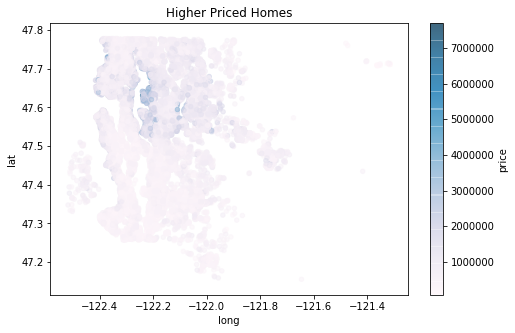

In [8]:
# Color coded plot of ALL homes by price and location
loc_hphomes = df.plot(kind='scatter', x='long', y='lat', alpha=0.5, figsize=(8,5), 
        c='price', cmap='PuBu', colorbar=True, sharex=False);
plt.title('Higher Priced Homes')

Text(0.5, 1.0, 'Higher Priced Homes')

Text(0.5, 1.0, 'Home Locations')

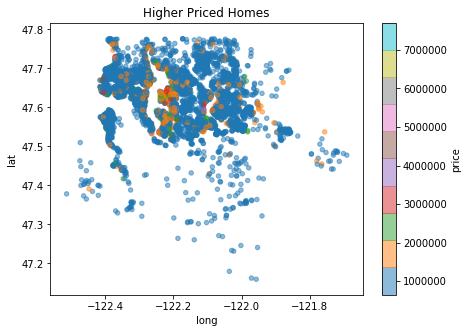

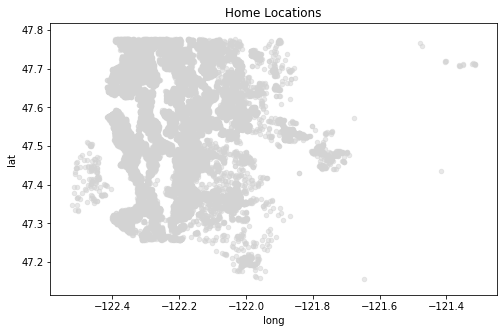

In [9]:
# Color coded plot of HIGHER priced homes by price and location
loc_hphomes = hp_homes.plot(kind='scatter', x='long', y='lat', alpha=0.5, 
        c='price', cmap='tab10', colorbar=True, sharex=False, figsize=(7,5));
plt.title('Higher Priced Homes')

# Color coded plot of ALL homes by price and location fairly sized for comparison
df.plot(kind='scatter', x='long', y='lat', alpha=0.5, 
        color='lightgrey', sharex=False, figsize=(8,5));
plt.title('Home Locations')

# Visual Relationships

## Pairwise plot with price
Since the price of homes is always a big consideration, let's look to find any interesting features

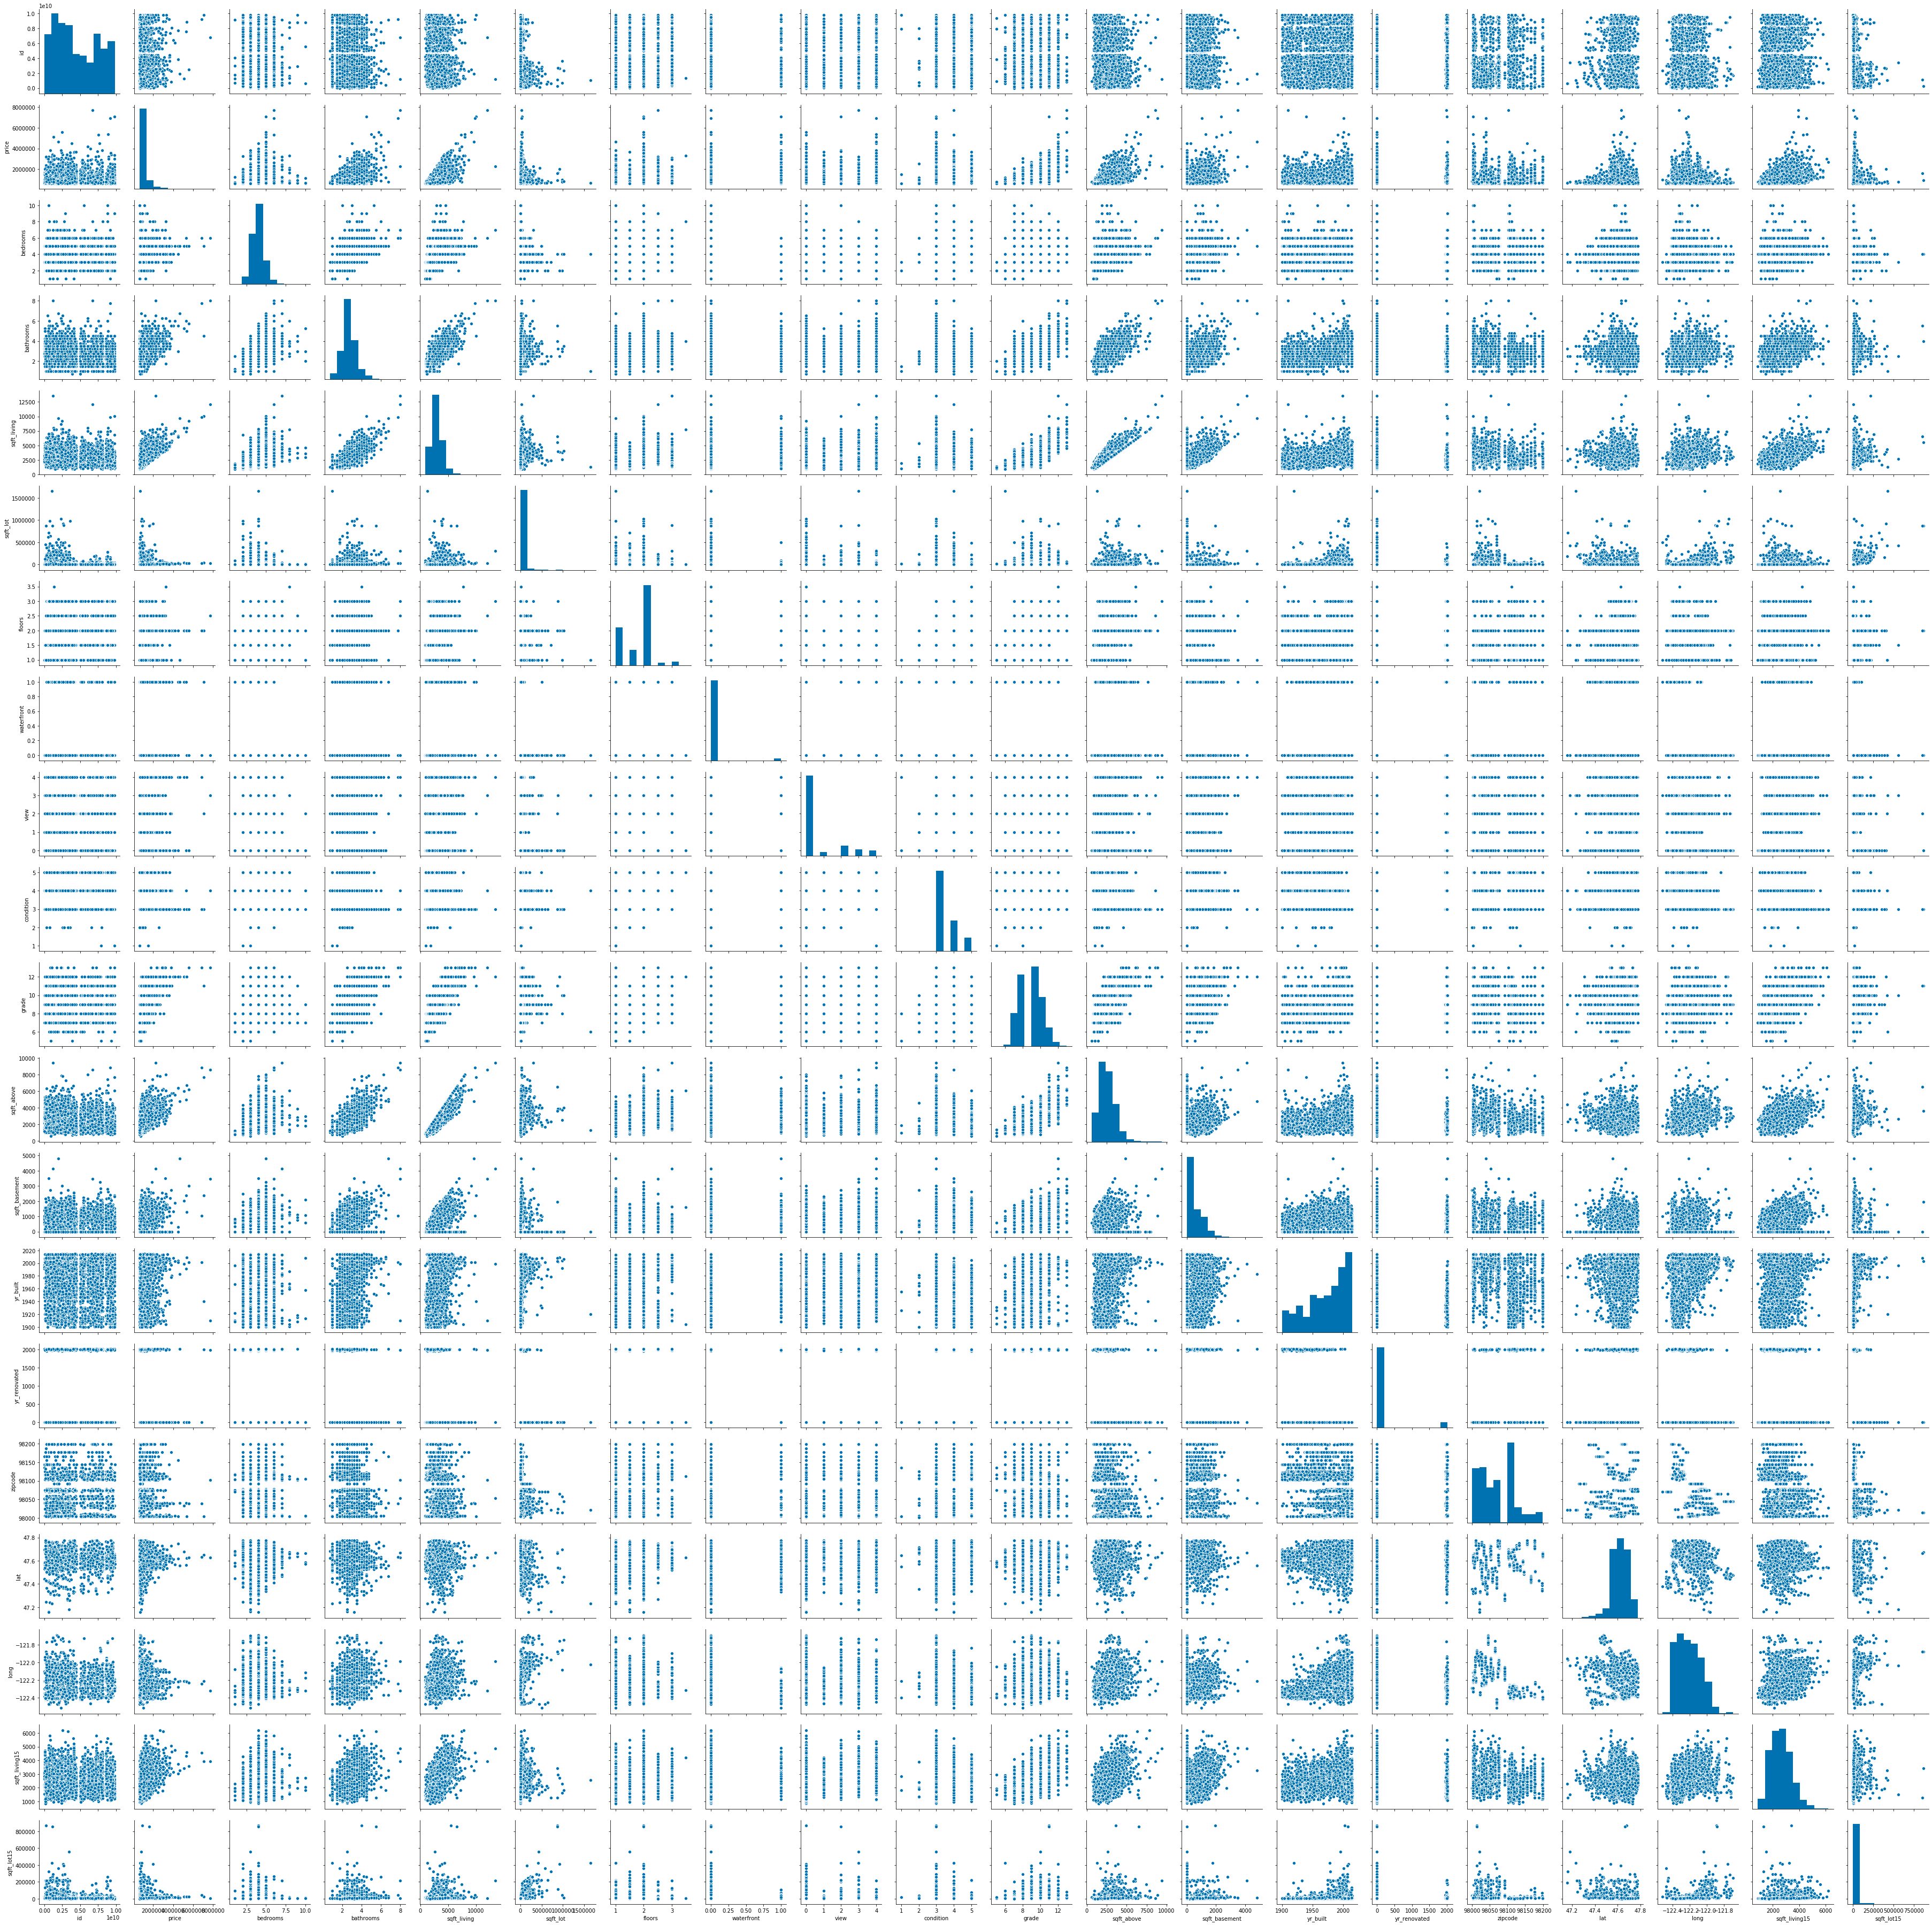

In [10]:
# Pairwise plot to find any interesting feature relationships
sns.pairplot(hp_homes)

In [10]:
hp_homes.grade.value_counts()

9     1662
8     1488
10    1020
7      697
11     389
12      88
6       33
13      13
5        4
Name: grade, dtype: int64

### Interesting features from pairwise plot
* Categorical data values:  bedrooms, floors, waterfront, view, condition, grade, and not as obvious bathrooms.
* Binary features: waterfront
* Features with too many '0' values: yr_renovated, sqft_basement, view, and waterfront
* Significantly skewed features: sqft_lot15, yr_built, sqft_basement, and price
* Zip Code and grade have two distinct sections: zip (980XX and 981XX), grade (bimodal with few values in the middle at 5 & 6)
* Somewhat linear relationships with price: sqft_living and sqft_above
* sqft_above and sqft_living are highly correlated to each other - may present collinearity
* Other interesting features: bathroom and grade

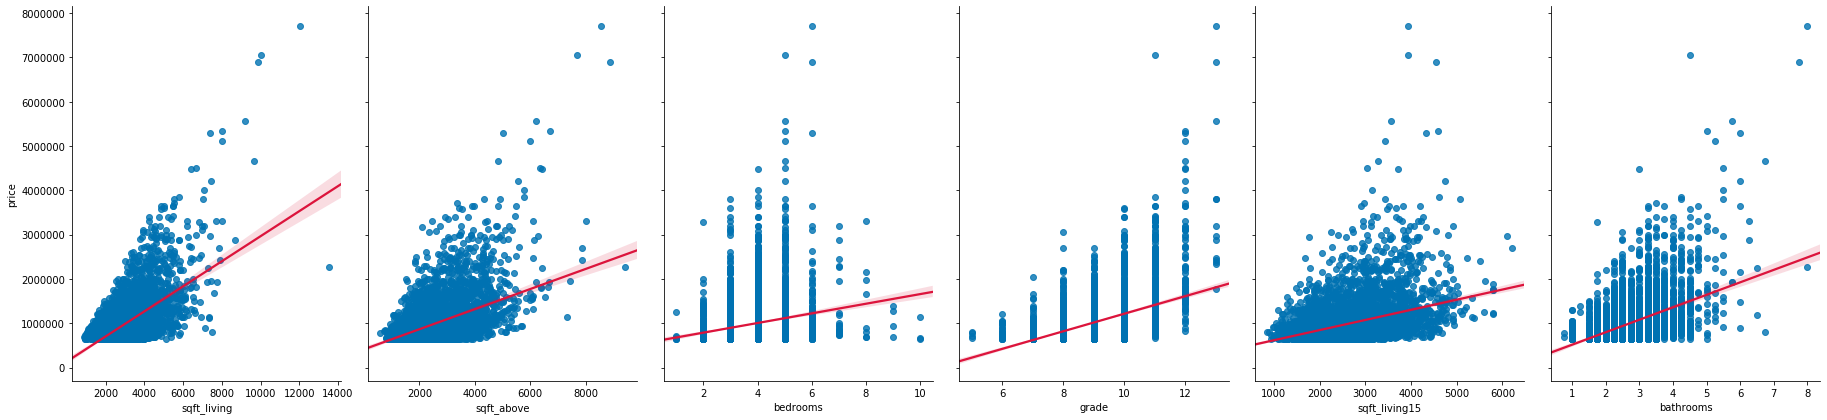

In [11]:
# visualize the pairwise relationship between the features and the response using pairplots 
sns.pairplot(x_vars=['sqft_living', 'sqft_above', 'bedrooms', 'grade', 'sqft_living15', 'bathrooms'], y_vars='price', data=hp_homes, 
             kind='reg', plot_kws={'line_kws':{'color':'crimson'}}, height=6, aspect=0.7)

### The above pairplots also show a regression line with margin of error shading
* grade and sqft_living seem to have the best line without much error when paired with price.

## Heatmap to show correlation

<Figure size 1296x936 with 0 Axes>

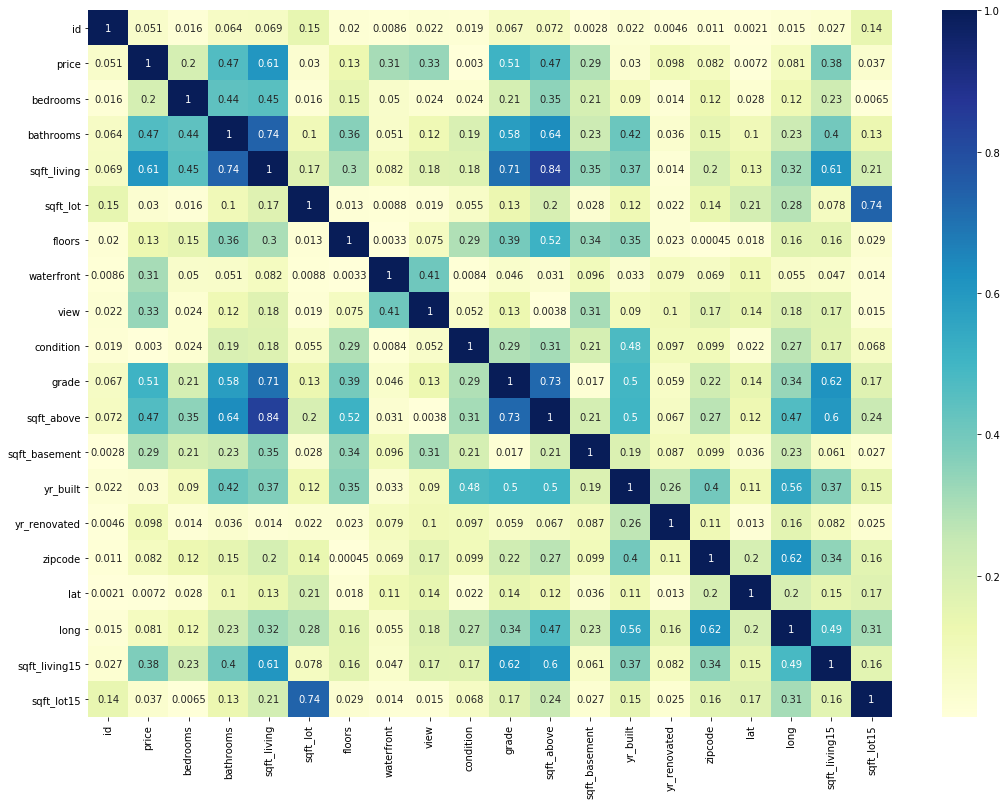

In [12]:
# heatmap to show relationships
plt.figure(figsize=(18,13))
sns.heatmap(hp_homes.corr().abs(), annot=True, cmap='YlGnBu')
plt.autoscale()
plt.show()

### Heatmap Relationships
* Features with higher correlations to price include: grade, sqft_living, and bathrooms
* sqft_living and grade are highly correlated with each other
* ** No features have a significantly high correlation to price

### Interesting Features
I decided to save the interesting features to it's own df for future investigations - hph_features

In [13]:
# Section off the interesting features
hph_features = hp_homes[['price', 'sqft_living', 'grade', 'bathrooms']]

# Predictive Values
Create OLS models for all features and return a comparison chart

In [14]:
# Create a function for finding OLS Regression summaries
def get_VIF(data, target, cols):
    X = data[cols]
    y = data[target]
    ols = sm.OLS(y, X)
    res = ols.fit()
    display(res.summary())
    jb, p_val, skew, kurt = sms.jarque_bera(res.resid)
    r2 = res.rsquared
    VIF = 1/(1-res.rsquared)
    return jb, p_val, skew, kurt, r2, VIF

In [15]:
# Loop through creating ols regression models and create a comparison chart
feature_summary = []
for feature in hph_features:
    d = {}
    # Make a summary chart
    d['feature'] = feature
    d['jb'],d['p'], d['sk'], d['kurt'], d['r2'], d['VIF'] = get_VIF(hp_homes, 'price', [feature])
    feature_summary.append(d)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.724e+34
Date:                Tue, 25 Feb 2020   Prob (F-statistic):                        0.00
Time:                        19:28:07   Log-Likelihood:                      1.0801e+05
No. Observations:                5394   AIC:                                 -2.160e+05
Df Residuals:                    5393   BIC:                                 -2.160e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
price          1.0000   6.06e-18   1.65e+17      0.000       1.000       1.000
==============================================================================
Omnibus:                     4964.871   Durbin-Watson:                   0.373
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           267108.507
Skew:                          -4.298   Prob(JB):                         0.00
Kurtosis:                      36.385   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/Users/shirlwilliams/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.879
Model:                            OLS   Adj. R-squared (uncentered):              0.879
Method:                 Least Squares   F-statistic:                          3.911e+04
Date:                Tue, 25 Feb 2020   Prob (F-statistic):                        0.00
Time:                        19:28:07   Log-Likelihood:                         -76969.
No. Observations:                5394   AIC:                                  1.539e+05
Df Residuals:                    5393   BIC:                                  1.539e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living   324.1117      1.639    197.762      0.000     320.899     327.325
==============================================================================
Omnibus:                     2489.464   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28723.550
Skew:                           1.903   Prob(JB):                         0.00
Kurtosis:                      13.645   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.850
Model:                            OLS   Adj. R-squared (uncentered):              0.850
Method:                 Least Squares   F-statistic:                          3.063e+04
Date:                Tue, 25 Feb 2020   Prob (F-statistic):                        0.00
Time:                        19:28:07   Log-Likelihood:                         -77539.
No. Observations:                5394   AIC:                                  1.551e+05
Df Residuals:                    5393   BIC:                                  1.551e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
grade       1.131e+05    646.318    175.008      0.000    1.12e+05    1.14e+05
==============================================================================
Omnibus:                     4922.181   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           266128.253
Skew:                           4.233   Prob(JB):                         0.00
Kurtosis:                      36.353   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.848
Model:                            OLS   Adj. R-squared (uncentered):              0.848
Method:                 Least Squares   F-statistic:                          3.011e+04
Date:                Tue, 25 Feb 2020   Prob (F-statistic):                        0.00
Time:                        19:28:07   Log-Likelihood:                         -77578.
No. Observations:                5394   AIC:                                  1.552e+05
Df Residuals:                    5393   BIC:                                  1.552e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bathrooms   3.617e+05   2084.680    173.510      0.000    3.58e+05    3.66e+05
==============================================================================
Omnibus:                     3344.500   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            67056.200
Skew:                           2.608   Prob(JB):                         0.00
Kurtosis:                      19.467   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
# Chart comparing specific data values from the OLS Regression above
summaries_df = pd.DataFrame(feature_summary)
summaries_df

feature             jb    p        sk       kurt        r2       VIF
0        price  267108.507467  0.0 -4.297771  36.385418  1.000000       inf
1  sqft_living   28723.550156  0.0  1.902995  13.645030  0.878817  8.251986
2        grade  266128.252831  0.0  4.233274  36.353043  0.850281  6.679167
3    bathrooms   67056.199530  0.0  2.608233  19.466558  0.848079  6.582352

## Predictive value comparison summary
* sqft_living has the highest r-squared and VIF showing a descent fit
* sqft_living has the lowest skew and kurtosis values which is expected since price is skewed right
* p-values are all 0 showing significance



# Distance
* The latitude and longitude for Seattle is 47.6062° N, 122.3321° W
* Let's find the distance from Seattle to each house

## Use function to find the distance from each home to Seattle

In [17]:
# Function to find the distance between each home and Seattle
def distance(origin):
    lat1, lon1 = origin
    lat2, lon2 = (47.6062, -122.3321)
    radius = 3959 # mi

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [18]:
# Create a list of tuples to use in the function above
tuples_list = list(zip(hp_homes.lat, hp_homes.long))
tuples_list[:5]

[(47.6561, -122.005),
 (47.6007, -122.145),
 (47.5714, -122.375),
 (47.5316, -122.233),
 (47.6386, -122.36)]

In [19]:
# Use the tuples in the function above to determine the distance from Seattle
dist_list = []
for item in tuples_list:
    dist_list.append(distance(item))
dist_list[:5]

[15.616759210119595,
 8.725191342213742,
 3.1271544018251087,
 6.922125531393065,
 2.588520633410436]

### Add the distance to hp_homes and hph_features

In [20]:
# Create the distance column in both hp_homes and hph_features
hp_homes['distance'] = dist_list
hp_homes.head()

hph_features['distance'] = dist_list
hph_features

id      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
5   7237550310  1230000.0         4       4.50         5420    101930     1.0   
10  1736800520   662500.0         3       2.50         3560      9796     1.0   
15  9297300055   650000.0         4       3.00         2950      5000     2.0   
21  2524049179  2000000.0         3       2.75         3050     44867     1.0   
26  1794500383   937000.0         3       1.75         2450      2691     2.0   

    waterfront  view  condition  ...  sqft_above  sqft_basement  yr_built  \
5            0     0          3  ...        3890           1530      2001   
10           0     0          3  ...        1860           1700      1965   
15           0     3          3  ...        1980            970      1979   
21           0     4          3  ...        2330            720      1968   
26           0     0          3  ...        1750            700      1915   

    yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  \
5              0    98053  47.6561 -122.005           4760      101930   
10             0    98007  47.6007 -122.145           2210        8925   
15             0    98126  47.5714 -122.375           2140        4000   
21             0    98040  47.5316 -122.233           4110       20336   
26             0    98119  47.6386 -122.360           1760        3573   

     distance  
5   15.616759  
10   8.725191  
15   3.127154  
21   6.922126  
26   2.588521  

[5 rows x 21 columns]

/Users/shirlwilliams/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


price  sqft_living  grade  bathrooms   distance
5      1230000.0         5420     11       4.50  15.616759
10      662500.0         3560      8       2.50   8.725191
15      650000.0         2950      9       3.00   3.127154
21     2000000.0         3050      9       2.75   6.922126
26      937000.0         2450      8       1.75   2.588521
...          ...          ...    ...        ...        ...
21403   679950.0         3600      9       2.75  12.704027
21404  1580000.0         3410     10       3.25   5.817249
21406   810000.0         3990      9       3.00  14.406827
21407  1540000.0         4470     11       3.75   6.407629
21413  1010000.0         3510      9       3.50   4.753375

[5394 rows x 5 columns]

### Distance summary

In [21]:
hp_homes.distance.describe()

count    5394.000000
mean        8.810997
std         5.149867
min         0.887338
25%         4.884538
50%         7.726602
75%        12.379321
max        35.518006
Name: distance, dtype: float64

* Commutes to downtown Seattle range from <1 mile to 35 miles
* Most commutes are from 5 to 12 miles
* Average commute is 8 miles

### Find the regression properties of price and distance from Seattle

In [22]:
# Use the ols regression function to get VIF and other values for price with distance
get_VIF(hp_homes, 'price', ['distance'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.546
Model:                            OLS   Adj. R-squared (uncentered):              0.546
Method:                 Least Squares   F-statistic:                              6477.
Date:                Tue, 25 Feb 2020   Prob (F-statistic):                        0.00
Time:                        19:28:44   Log-Likelihood:                         -80533.
No. Observations:                5394   AIC:                                  1.611e+05
Df Residuals:                    5393   BIC:                                  1.611e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
distance     7.92e+04    984.161     80.477      0.000    7.73e+04    8.11e+04
==============================================================================
Omnibus:                     1952.162   Durbin-Watson:                   1.663
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18134.316
Skew:                           1.462   Prob(JB):                         0.00
Kurtosis:                      11.493   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(18134.315963619032,
 0.0,
 1.4624557121568953,
 11.493026833168749,
 0.5456468608492466,
 2.2009312004955737)

### By itself distance is not as good a predictor as sqft_living

## Visual Exploration with Distance


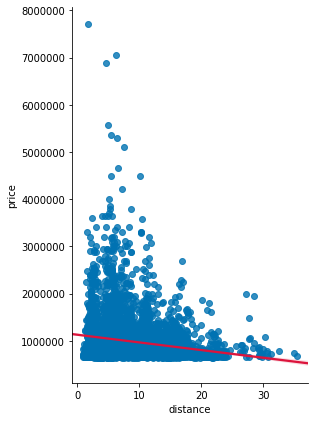

In [23]:
# Pairplot with price and regression line
sns.pairplot(x_vars=['distance'], y_vars='price', data=hp_homes,
             kind='reg', plot_kws={'line_kws':{'color':'crimson'}}, height=6, aspect=0.7)
plt.show();

Text(0.5, 1.0, 'Distance')

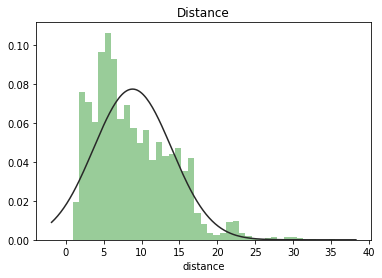

In [24]:
# Distplot to show characteristics of the distribution
sns.distplot(hp_homes['distance'], color='green', label='distance', fit=norm, kde=False)
plt.title('Distance')
plt.show()

Text(0.5, 1, 'Distance from Seattle\nColored by Grade')

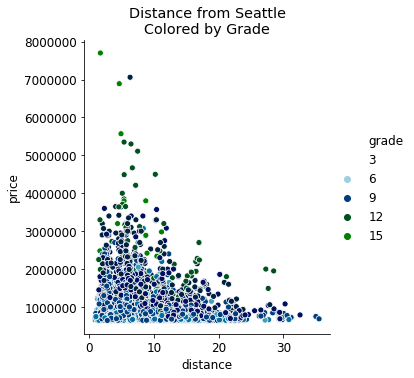

In [60]:
sns.relplot(x="distance", y="price", hue="grade", data=hp_homes, palette='ocean_r');
sns.set_context(None, rc={"font.scale":1.2})
plt.title('Distance from Seattle\nColored by Grade')

<Figure size 720x576 with 0 Axes>

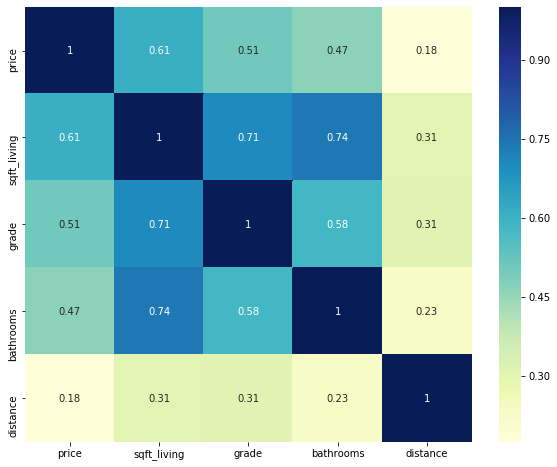

In [27]:
# heatmap to show key relationships with distance added
plt.figure(figsize=(10,8))
sns.heatmap(hph_features.corr().abs(), annot=True, cmap='YlGnBu')
plt.autoscale()
plt.show()

### Visual representation of Distance relationship
note further exploration
* linear regression plot implies a linear relationship
* the distplot shows a somewhat normal distribution
* the correlation heatmap shows <b>no</b> significant correlation with price

# Explore multiple predictive values
Let's see if we can improve our predictive model with multiple features:


## Baseline Model

In [28]:
# Begin regresstion
regression = LinearRegression()

# Set up the independent and dependent variables
y = hp_homes.price
X = hp_homes.drop(columns='price')
all_data = pd.concat([y,X], axis = 1)

# Use cross validation
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))
baseline

0.661209040080179

## Pairwise comparison model

In [29]:
# Create combinations of key values to explore by pairs
combos = []
combos = list(combinations(X, 2))

In [30]:
# Find the best pairs, create a copy of X since we'll be manipulating the columns
interactions = []
data = X.copy()
for comb in combos:
    data['interaction'] = data[comb[0]] * data[comb[1]]
    score = np.mean(cross_val_score(regression, data, y, scoring='r2', cv=crossvalidation))
    if score > baseline: interactions.append((comb[0], comb[1], round(score,3)))
            
print('Top 3 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:3])

Top 3 interactions: [('sqft_living', 'grade', 0.687), ('sqft_living', 'distance', 0.684), ('bathrooms', 'grade', 0.683)]


### Pairwise comparison model investigation
When compared by pairs, we should explore the key combinations below:
* sqft_living and grade
* sqft_living and distance
* bathrooms and grade

In [31]:
# Create the OLS model by comparing each feature pair against price and create a summary table
pair_summaries = []

# Compare price against grade and bathrooms
d = {}
# Make a summary chart with key values
d['feature'] = 'grade & sqft_living'
d['jb'],d['p'], d['sk'], d['kurt'], d['r2'], d['VIF'] = get_VIF(hp_homes, 'price', ['grade', 'sqft_living'])
pair_summaries.append(d)

# Compare price against grade and sqft_living
d = {}
# Make a summary chart with key values
d['feature'] = 'sqft_living & distance'
d['jb'],d['p'], d['sk'], d['kurt'], d['r2'], d['VIF'] = get_VIF(hp_homes, 'price', ['distance', 'sqft_living'])
pair_summaries.append(d)

# Compare price against grade and distance
d = {}
# Make a summary chart with key values
d['feature'] = 'bathrooms & grade'
d['jb'],d['p'], d['sk'], d['kurt'], d['r2'], d['VIF'] = get_VIF(hp_homes, 'price', ['grade', 'bathrooms'])
pair_summaries.append(d)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.882
Model:                            OLS   Adj. R-squared (uncentered):              0.882
Method:                 Least Squares   F-statistic:                          2.017e+04
Date:                Tue, 25 Feb 2020   Prob (F-statistic):                        0.00
Time:                        19:48:39   Log-Likelihood:                         -76895.
No. Observations:                5394   AIC:                                  1.538e+05
Df Residuals:                    5392   BIC:                                  1.538e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
grade        2.815e+04   2300.260     12.237      0.000    2.36e+04    3.27e+04
sqft_living   247.2806      6.483     38.141      0.000     234.571     259.991
==============================================================================
Omnibus:                     3435.843   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            69205.418
Skew:                           2.710   Prob(JB):                         0.00
Kurtosis:                      19.689   Cond. No.                     1.42e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.901
Model:                            OLS   Adj. R-squared (uncentered):              0.901
Method:                 Least Squares   F-statistic:                          2.461e+04
Date:                Tue, 25 Feb 2020   Prob (F-statistic):                        0.00
Time:                        19:48:39   Log-Likelihood:                         -76416.
No. Observations:                5394   AIC:                                  1.528e+05
Df Residuals:                    5392   BIC:                                  1.528e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
distance     -3.23e+04    922.286    -35.024      0.000   -3.41e+04   -3.05e+04
sqft_living   414.4664      2.974    139.368      0.000     408.636     420.296
==============================================================================
Omnibus:                     1648.164   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16350.683
Skew:                           1.169   Prob(JB):                         0.00
Kurtosis:                      11.202   Cond. No.                         623.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.861
Model:                            OLS   Adj. R-squared (uncentered):              0.861
Method:                 Least Squares   F-statistic:                          1.669e+04
Date:                Tue, 25 Feb 2020   Prob (F-statistic):                        0.00
Time:                        19:48:39   Log-Likelihood:                         -77339.
No. Observations:                5394   AIC:                                  1.547e+05
Df Residuals:                    5392   BIC:                                  1.547e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
grade       5.999e+04   2684.808     22.343      0.000    5.47e+04    6.52e+04
bathrooms   1.749e+05   8596.776     20.342      0.000    1.58e+05    1.92e+05
==============================================================================
Omnibus:                     4506.633   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           183868.440
Skew:                           3.768   Prob(JB):                         0.00
Kurtosis:                      30.592   Cond. No.                         15.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
# Chart comparing specific data values from the OLS Regression above
summaries_df = pd.DataFrame(pair_summaries)
summaries_df.head()

feature             jb    p        sk       kurt        r2  \
0     grade & sqft_living   69205.418303  0.0  2.710386  19.689428  0.882092   
1  sqft_living & distance   16350.683461  0.0  1.169364  11.202493  0.901276   
2       bathrooms & grade  183868.440460  0.0  3.767732  30.592007  0.860952   

         VIF  
0   8.481161  
1  10.129264  
2   7.191756

## Continue comparisons by adding features for a better model

In [33]:
# Create the OLS model by comparing three features against price and create a summary table
triple_summaries = []

# Compare price against grade and bathrooms
d = {}
# Make a summary chart with key values
d['feature'] = 'sqft_living, distance & grade'
d['jb'],d['p'], d['sk'], d['kurt'], d['r2'], d['VIF'] = get_VIF(hp_homes, 'price', ['distance','grade', 'sqft_living'])
triple_summaries.append(d)

# Compare price against grade and sqft_living
d = {}
# Make a summary chart with key values
d['feature'] = 'sqft_living, distance & bathrooms'
d['jb'],d['p'], d['sk'], d['kurt'], d['r2'], d['VIF'] = get_VIF(hp_homes, 'price', ['distance', 'sqft_living', 'bathrooms'])
triple_summaries.append(d)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.913
Model:                            OLS   Adj. R-squared (uncentered):              0.913
Method:                 Least Squares   F-statistic:                          1.876e+04
Date:                Tue, 25 Feb 2020   Prob (F-statistic):                        0.00
Time:                        19:48:52   Log-Likelihood:                         -76088.
No. Observations:                5394   AIC:                                  1.522e+05
Df Residuals:                    5391   BIC:                                  1.522e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
distance     -3.94e+04    908.629    -43.358      0.000   -4.12e+04   -3.76e+04
grade        5.474e+04   2073.655     26.398      0.000    5.07e+04    5.88e+04
sqft_living   284.8968      5.650     50.423      0.000     273.820     295.973
==============================================================================
Omnibus:                     3446.186   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            77317.305
Skew:                           2.682   Prob(JB):                         0.00
Kurtosis:                      20.755   Cond. No.                     1.50e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.904
Model:                            OLS   Adj. R-squared (uncentered):              0.904
Method:                 Least Squares   F-statistic:                          1.687e+04
Date:                Tue, 25 Feb 2020   Prob (F-statistic):                        0.00
Time:                        19:48:52   Log-Likelihood:                         -76347.
No. Observations:                5394   AIC:                                  1.527e+05
Df Residuals:                    5391   BIC:                                  1.527e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
distance    -3.371e+04    918.581    -36.700      0.000   -3.55e+04   -3.19e+04
sqft_living   341.7444      6.840     49.965      0.000     328.336     355.153
bathrooms     8.93e+04   7585.158     11.773      0.000    7.44e+04    1.04e+05
==============================================================================
Omnibus:                     2056.135   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23231.080
Skew:                           1.496   Prob(JB):                         0.00
Kurtosis:                      12.716   Cond. No.                     5.19e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
# Chart comparing specific data values from the OLS Regression above
summaries_df = pd.DataFrame(triple_summaries)
summaries_df.head()

feature            jb    p        sk       kurt  \
0      sqft_living, distance & grade  77317.305048  0.0  2.681502  20.755363   
1  sqft_living, distance & bathrooms  23231.079811  0.0  1.496231  12.716443   

         r2        VIF  
0  0.912577  11.438611  
1  0.903751  10.389681

### Triple feature comparison summary
<b>Feature: <i>Jarque-Bera,   Pval, Skew,      Kurtosis,   r-squared, VIF</i> </b>
<br>sqft_living, distance & grade	77317.305048,  0.0,  2.681502,  20.755363,  0.912577,  11.438611
<br>sqft_living & distance	16350.683461,  0.0,  1.169364,  11.202493,  0.901276,  10.129264
* The r-squared value and VIF show improvements over the double model
* But since the JB, Skew, Kurtosis, and Condition Number are higher and includes a warning about multicollinearity, the pair model with sqft_living and distance should be used.

## Investigate sqft_living and distance model

In [80]:
f = 'price~sqft_living+distance'
model = smf.ols(formula=f, data=hp_homes).fit()

/Users/shirlwilliams/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



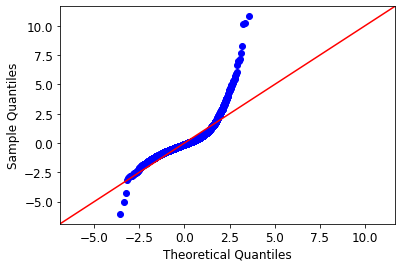

In [81]:
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

### Model Issues
The model only works for about half the values. Let's see if we can help the model by normalizing sqft_living.

## Log fit of sqft_living

In [87]:
# Convert sqft_living to a logarithmic function
logsqft = np.log(hp_homes['sqft_living'])

In [88]:
# Min-Max Scaling
hph_features['sqft_living'] = (logsqft-min(logsqft))/(max(logsqft)-min(logsqft))

/Users/shirlwilliams/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Reworking results of sqft_living

In [89]:
f = 'price~sqft_living'
model = smf.ols(formula=f, data=hph_features).fit()

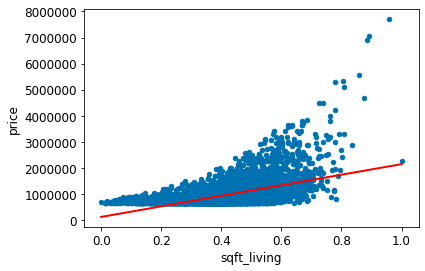

In [91]:
# create a DataFrame with the minimum and maximum values of sqft_living
X_new = pd.DataFrame({'sqft_living': [hph_features.sqft_living.min(), hph_features.sqft_living.max()]})

# make predictions for those x values and store them
preds = model.predict(X_new)

# first, plot the observed data and the least squares line
hph_features.plot(kind='scatter', x='sqft_living', y='price')
plt.plot(X_new, preds, c='red', linewidth=2)
plt.show()

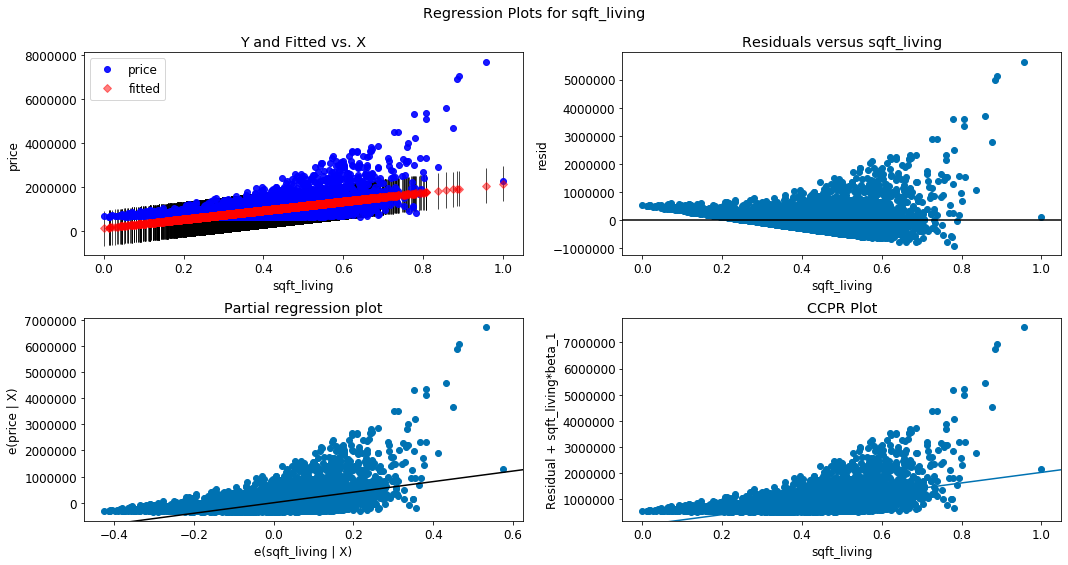

In [92]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_living", fig=fig)
plt.show()

In [93]:
f = 'price~sqft_living+distance'
model = smf.ols(formula=f, data=hph_features).fit()

/Users/shirlwilliams/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



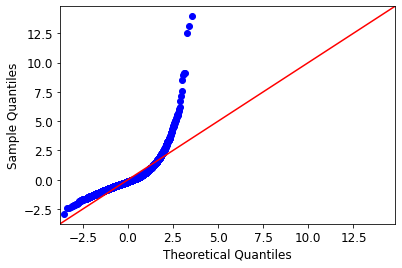

In [94]:
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

### Evidence of heteroscedasticity
Even using a logarithmic function has not significantly lessened the widening spread about line of best fit at higher values

# Interesting Factor
Higher priced homes have higher grade building materials.

Text(0.5, 1, 'Price by Home Grade')

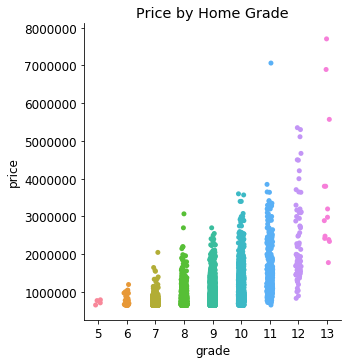

In [61]:
sns.catplot(x="grade",y="price",data=hp_homes)
sns.set_context(None, rc={"font.scale":1.2})
plt.title('Price by Home Grade')

# Results
* 
* sqft_living & distance	16350.683461	0.0	1.169364	11.202493	0.901276	10.129264


## Interpretation of OLS summary scores
* The skew score of 1.17 suggests a slight positive skew to the distribution, but still well within the bounds of normality.
* The kurtosis score of 11.2 indicates some extreme values in the tail, which we know are some of the highest priced homes.
* The p-values are all below 0, meaning that there is virtually no chance that the null-hypothesis is true (null-hypothesis being that random chance resulted in the data set and no real correlation between variables exists).
* The F-statistic is enormous (30,670) and it's probability score is 0.00. This means that the variance between the groups is enormous while the variance within the groups is very small (exactly what we want). The probability againt refers to the chance that what we're seeing is actually unrelated to our variables (here, there is no chance for the null hypothesis to be true).
* The Jarque-Bera (JB) score is around 205. We ideally want a very low JB. Because the sample size plays into the actual score, this number can get inflated quickly. However, considering that the first JB score we saw was around 1000, I'd say this is a vast improvement. The JB test is a goodness-of-fit test to see if our sample data has a skew and kurtosis matching a true normal distribution.
* The adjusted-$R^2$ score is 0.885 (as is the regular $R^2$ score), which essentially means that approximately 88.5% of the variance in a house's sale price can be predicted by the variables in the model we have created.

In [135]:
X = hp_homes[['sqft_living', 'distance']]
y = hp_homes.price
ols = sm.OLS(y, X)
res = ols.fit()
display(res.summary())




<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.901
Model:                            OLS   Adj. R-squared (uncentered):              0.901
Method:                 Least Squares   F-statistic:                          2.461e+04
Date:                Wed, 26 Feb 2020   Prob (F-statistic):                        0.00
Time:                        02:32:05   Log-Likelihood:                         -76416.
No. Observations:                5394   AIC:                                  1.528e+05
Df Residuals:                    5392   BIC:                                  1.528e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living   414.4664      2.974    139.368      0.000     408.636     420.296
distance     -3.23e+04    922.286    -35.024      0.000   -3.41e+04   -3.05e+04
==============================================================================
Omnibus:                     1648.164   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16350.683
Skew:                           1.169   Prob(JB):                         0.00
Kurtosis:                      11.202   Cond. No.                         623.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [119]:
sms.jarque_bera(res.resid)
sms.recursive_olsresiduals

(16350.683460917588, 0.0, 1.1693636960807847, 11.202493059261533)

<function statsmodels.sandbox.stats.diagnostic.recursive_olsresiduals(olsresults, skip=None, lamda=0.0, alpha=0.95)>

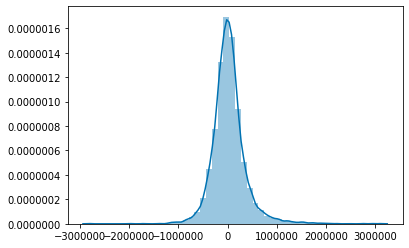

In [120]:
# plot residuals
residuals = res.resid
sns.distplot(residuals)
plt.show()

In [ ]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_living", fig=fig)
plt.show()

# Moderate Homes
Dataset price outliers removed.

In [145]:
# Look at moderate homes
norm_homes = pd.read_csv("super_cleaned_kings.csv")
norm_homes = norm_homes.drop(columns='Unnamed: 0').head()

In [146]:
# Create a list of tuples to use in the function above
tuples_list = list(zip(norm_homes.lat, norm_homes.long))
tuples_list[:5]

[(47.5112, -122.257),
 (47.721, -122.319),
 (47.7379, -122.233),
 (47.5208, -122.393),
 (47.6168, -122.045)]

In [147]:
# Use the tuples in the function above to determine the distance from Seattle
dist_list = []
for item in tuples_list:
    dist_list.append(distance(item))
dist_list[:5]

[7.4399416517316475,
 7.955793584755001,
 10.201655343228099,
 6.548558284350337,
 13.393847623644067]

In [148]:
# Add the distance to norm_homes
norm_homes['distance'] = dist_list
norm_homes.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  01/01/1970  221900.0         3       1.00         1180   
1  6414100192  01/01/1970  538000.0         3       2.25         2570   
2  5631500400  01/01/1970  180000.0         2       1.00          770   
3  2487200875  01/01/1970  604000.0         4       3.00         1960   
4  1954400510  01/01/1970  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...        1180              0   
1      7242     2.0           0     0  ...        2170            400   
2     10000     1.0           0     0  ...         770              0   
3      5000     1.0           0     0  ...        1050            910   
4      8080     1.0           0     0  ...        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15   distance  
0        5650   7.439942  
1        7639   7.955794  
2        8062  10.201655  
3        5000   6.548558  
4        7503  13.393848  

[5 rows x 22 columns]

### Find the regression properties of price and distance from Seattle

In [149]:
# Use the ols regression function to get VIF and other values for price with distance
get_VIF(norm_homes, 'price', ['distance'])

/Users/shirlwilliams/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/stats/stattools.py:71: ValueWarning:

omni_normtest is not valid with less than 8 observations; 5 samples were given.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.777
Model:                            OLS   Adj. R-squared (uncentered):              0.721
Method:                 Least Squares   F-statistic:                              13.91
Date:                Wed, 26 Feb 2020   Prob (F-statistic):                      0.0203
Time:                        03:48:13   Log-Likelihood:                         -68.391
No. Observations:                   5   AIC:                                      138.8
Df Residuals:                       4   BIC:                                      138.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
distance    4.169e+04   1.12e+04      3.730      0.020    1.07e+04    7.27e+04
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.448
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.444
Skew:                           0.199   Prob(JB):                        0.801
Kurtosis:                       1.596   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(0.4439727401221086,
 0.8009262808365711,
 0.19937216578631792,
 1.5956951503947538,
 0.7766737937449326,
 4.477754835712701)

In [151]:
# Use the ols regression function to get VIF and other values for price with distance
get_VIF(norm_homes, 'price', ['distance','sqft_living'])

/Users/shirlwilliams/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/stats/stattools.py:71: ValueWarning:

omni_normtest is not valid with less than 8 observations; 5 samples were given.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.940
Method:                 Least Squares   F-statistic:                              40.09
Date:                Wed, 26 Feb 2020   Prob (F-statistic):                     0.00685
Time:                        03:49:00   Log-Likelihood:                         -63.833
No. Observations:                   5   AIC:                                      131.7
Df Residuals:                       3   BIC:                                      130.9
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
distance     3960.6237   1.09e+04      0.364      0.740   -3.07e+04    3.86e+04
sqft_living   231.8655     58.749      3.947      0.029      44.899     418.832
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.896
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.632
Skew:                           0.423   Prob(JB):                        0.729
Kurtosis:                       1.477   Cond. No.                         388.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(0.6323493822399602,
 0.7289321010794432,
 0.42309507549336556,
 1.4770951234154965,
 0.9639339808783235,
 27.726930344773677)

### Distance summary

In [152]:
norm_homes.distance.describe()

count     5.000000
mean      9.107959
std       2.748878
min       6.548558
25%       7.439942
50%       7.955794
75%      10.201655
max      13.393848
Name: distance, dtype: float64

* Commutes to downtown Seattle range from <1 mile to 35 miles
* Most commutes are from 5 to 12 miles
* Average commute is 8 miles

In [137]:
# Use the ols regression function to get VIF and other values for price with distance
get_VIF(hp_homes, 'price', ['distance'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.546
Model:                            OLS   Adj. R-squared (uncentered):              0.546
Method:                 Least Squares   F-statistic:                              6477.
Date:                Wed, 26 Feb 2020   Prob (F-statistic):                        0.00
Time:                        03:38:40   Log-Likelihood:                         -80533.
No. Observations:                5394   AIC:                                  1.611e+05
Df Residuals:                    5393   BIC:                                  1.611e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
distance     7.92e+04    984.161     80.477      0.000    7.73e+04    8.11e+04
==============================================================================
Omnibus:                     1952.162   Durbin-Watson:                   1.663
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18134.316
Skew:                           1.462   Prob(JB):                         0.00
Kurtosis:                      11.493   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(18134.315963619032,
 0.0,
 1.4624557121568953,
 11.493026833168749,
 0.5456468608492466,
 2.2009312004955737)